## Import Libraries

In [1]:
# Import Libraries
import os
import dill
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from time import time
from IPython.display import display
import sklearn.feature_selection as FeatureSelection
import sklearn.metrics as Metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve

# Model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, \
                         ExtraTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor, \
                              RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, \
                        NuSVR, \
                        SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import AdaBoostRegressor, \
                             BaggingRegressor, \
                             ExtraTreesRegressor, \
                             GradientBoostingRegressor, \
                             RandomForestRegressor

## Load Session (Optional)
Turn the variable to True if you want to load last
jupyter session. Then just run the following cell and
then pick the which other
cells you want to run.

In [2]:
is_load_session = False
path_session = "../Session/credit_card_fraud.db"

# Make sure Session folder exists
if not os.path.isdir("../Session"):
	os.mkdir("../Session")

if (is_load_session and os.path.isfile(path_session)):
	dill.load_session(path_session)

## Define Necessary Functions

In [3]:
# Define Necessary Functions

# Function to print out model score
def printModelScore(Y_true, Y_prediction):
	print("\t+ Explained Variance: {}".format(Metrics.explained_variance_score(Y_true, Y_prediction)))
	print("\t+ Mean Absolute Error: {}".format(Metrics.mean_absolute_error(Y_true, Y_prediction)))
	print("\t+ Mean Squared Error: {}".format(Metrics.mean_squared_error(Y_true, Y_prediction)))
	print("\t+ Median Absolute Error: {}".format(Metrics.median_absolute_error(Y_true, Y_prediction)))
	print("\t+ R2 Score: {}".format(Metrics.r2_score(Y_true, Y_prediction)))

# Function to display scores from GridSearchCV
def printScore(result):
	def displayScore(result, key_list, param_list):
		tmp_result_mean = {}
		tmp_result_std = {}
		for x in param_list:
			tmp_result_mean[x] = result[x]
			tmp_result_std[x] = result[x]
		for x, y in key_list:
			tmp_result_mean[x] = result[x]
			tmp_result_std[y] = result[y]
		display(pd.DataFrame(tmp_result_mean))
		display(pd.DataFrame(tmp_result_std))
	key_list_mean = [x for x in result.keys() if x.split("_")[0] == "mean"]
	key_list_std = [x for x in result.keys() if x.split("_")[0] == "std"]
	key_list = [(x, y) for x in key_list_mean for y in key_list_std if "".join(x.split("_")[1:]) == "".join(y.split("_")[1:])]
	key_list_train = [(x, y) for x, y in key_list if x.split("_")[1] == "train"]
	key_list_test = [(x, y) for x, y in key_list if x.split("_")[1] == "test"]
	param_list = [x for x in result.keys() if x.split("__")[0] == "param_model"]
	print("\t============= Train ================")
	displayScore(result, key_list_train, param_list)
	print("\n")
	print("\t============= Test = ===============")
	displayScore(result, key_list_test, param_list)
	print("\n")

# Function to plot curve
def plotScore(x, y, x_label, y_label, title):
	plt.figure()
	plt.clf()

	plt.plot(x, y, "o-")
	plt.xlabel(x_label)
	plt.ylabel(y_label)
	plt.title(title)

	plt.show()

def plotMultiLineScore(x, y, y_std, line_label, x_label, y_label, title):
	plt.figure()
	plt.clf()

	for i in range(len(line_label)):
		plt.fill_between(x[i], y[i] - y_std[i], y[i] + y_std[i], alpha = 0.1)
		plt.plot(x[i], y[i], "o-", label = line_label[i])

	plt.xlabel(x_label)
	plt.ylabel(y_label)
	plt.title(title)
	plt.legend()

	plt.show()

# Function to plot Feature Scores
def plotScoreFeature(scores, title):
	plt.figure()
	plt.clf()

	y_pos = np.arange(len(scores))
	plt.bar(y_pos, scores, align="center", alpha = 0.5)
	plt.xticks(y_pos, [str(x) for x in range(len(scores))])
	plt.ylabel("Score")
	plt.title(title)

	plt.show()

# Function to comput Feature Scores
def computeFeatureScores(X, Y, columns_numerical):
	X_numerical = X.loc[:, X.columns.isin(columns_numerical)]
	scores = {}

	# Compute Variance for Numerical Data
	print("\t+ Computing Variance")
	score_variance = np.var(X_numerical, axis = 0)
	scores["variance"] = score_variance

	# Compute f_regression Score for Numerical Data
	print("\t+ Computing F-score Regression")
	_, score_f_regression = FeatureSelection.f_regression(X_numerical, Y)
	score_f_regression = np.nan_to_num(score_f_regression)
	score_f_regression = -np.log10(score_f_regression)
	score_f_regression[np.isinf(score_f_regression)] = 0
	score_f_regression /= score_f_regression.max()
	scores["f_regression"] = score_f_regression

	# # Compute mutual_info_regression Score for Numerical Data
	# print("Computing Mutual Info Regression")
	# score_mutual_info_regression = FeatureSelection.mutual_info_regression(X, Y)
	# score_mutual_info_regression /= score_mutual_info_regression.max()
	# scores["mutual_info_regression"] = score_mutual_info_regression

	# Generate Plots
	print("\t+ Plotting Variance")
	plotScoreFeature(score_variance, "Feature Variance")
	print(list(zip(range(len(X.columns)), X.columns)))
	print("\t+ Plotting F-score Regression")
	plotScoreFeature(score_f_regression, "Feature Scores ANOVA Test")
	print(list(zip(range(len(columns_numerical)), columns_numerical)))
	# print("Plotting Mutual Info Regression")
	# plotScoreFeature(score_mutual_info_regression, "Feature Scores Mutual Information Test")
	# print(list(zip(range(len(X.columns)), X.columns)))

	return(scores)

def checkModelSpecificationParam(model_specification, key):
	if (model_specification.get(key) is not None):
		if ((model_specification[key].get("data") is None) or (model_specification[key].get("parameter") is None)):
			return False
	else:
		return False
	return True

def addParameters(param_grid, model_specification, param_selected):
	model_specification_selected = model_specification[param_selected]["parameter"]
	for key in model_specification_selected.keys():
		param_grid[param_selected + "__{}".format(key)] = model_specification_selected[key]
	return param_grid

# Function to run model in a pipelined manner
def runModel(model_specification, X, Y):
	model_pipeline = []
	param_grid = {}

	# Build model pipeline
	if (checkModelSpecificationParam(model_specification, "feature_transformation")):
		model_pipeline.append(("feature_transformation", model_specification["feature_transformation"]["data"]))
		param_grid = addParameters(param_grid, model_specification, "feature_transformation")

	if (checkModelSpecificationParam(model_specification, "feature_selection")):
		model_pipeline.append(("feature_selection", model_specification["feature_selection"]["data"]))
		param_grid = addParameters(param_grid, model_specification, "feature_selection")

	if (checkModelSpecificationParam(model_specification, "model")):
		model_pipeline.append(("model", model_specification["model"]["data"]))
		param_grid = addParameters(param_grid, model_specification, "model")

	model_pipeline = Pipeline(steps = model_pipeline)

	result = GridSearchCV(model_pipeline, param_grid)
	if (model_specification.get("grid_search") is not None):
		result = GridSearchCV(model_pipeline, param_grid, **model_specification["grid_search"])
	
	result = result.fit(X, Y)
	return result

## Define Global Variables needed

In [4]:
# Define Variables
path_dataset_train   =   "../train.csv"
path_dataset_test    =   "../test.csv"
model_specification_default = {"grid_search" : {"n_jobs" : -1, "cv" : 5, "refit" : "neg_mean_squared_error", "return_train_score" : True, "verbose" : 50,
                                                "scoring" : ["explained_variance", "neg_mean_absolute_error",
                                                             "neg_mean_squared_error", "neg_median_absolute_error", "r2"]}}
list_model = [("Linear Regression", LinearRegression()),
              ("Decision Tree Regressor", DecisionTreeRegressor()),
              ("Extra Tree Regressor", ExtraTreeRegressor()),
              #("Kernel Ridge", KernelRidge()),
              ("KNeighbors Regressor", KNeighborsRegressor()),
              #("RadiusNeighborsRegressor", RadiusNeighborsRegressor()),
              ("MLP Regressor", MLPRegressor()),
              ("Linear SVR", LinearSVR()),
              #("Nu SVR", NuSVR()),
              #("SVR", SVR()),
              #("Gaussian Process Regressor", GaussianProcessRegressor()),
              ("Ada Boost Regressor", AdaBoostRegressor()),
              ("Bagging Regressor", BaggingRegressor()),
              ("Extra Trees Regressor", ExtraTreesRegressor()),
              ("Gradient Boosting Regressor", GradientBoostingRegressor()),
              ("Random Forest Regressor", RandomForestRegressor()),
             ]
list_score = [("Explained Variance", "explained_variance"),
              ("Mean Absolute Error", "neg_mean_absolute_error"),
              ("Mean Squared Error", "neg_mean_squared_error"),
              ("Median Absolute Error", "neg_median_absolute_error"),
              ("R2", "r2"),
              ]

## Load and Inspect Dataset

In [5]:
# Load Dataset
dataset_train = pd.read_csv(path_dataset_train)
dataset_test = pd.read_csv(path_dataset_test)

dataset_X_train   =   dataset_train.iloc[:, 1:29]
dataset_X_test    =   dataset_test.iloc[:, 1:29]
dataset_Y_train   =   dataset_train.loc[:, "Amount"]
dataset_Y_test    =   dataset_test.loc[:, "Amount"]

# Inspect Dataset
print(dataset_X_train.head())
print(dataset_X_test.head())
print(dataset_Y_train.head())
print(dataset_Y_test.head())

# Print Columns
print(dataset_X_train.columns)
print(dataset_X_test.columns)
print(dataset_Y_train.name)
print(dataset_Y_test.name)

# Print Shape
print("Shape of X train: {}\n".format(dataset_X_train.shape))
print("Shape of X test: {}\n".format(dataset_X_test.shape))
print("Shape of Y train: {}\n".format(dataset_Y_train.shape))
print("Shape of Y test: {}\n".format(dataset_Y_test.shape))

# Make Model folder if it does not exist
if not os.path.isdir("../Model"):
	os.mkdir("../Model")

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
2 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
3 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
4 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   

         V8        V9       V10  ...       V19       V20       V21       V22  \
0  0.098698  0.363787  0.090794  ...  0.403993  0.251412 -0.018307  0.277838   
1  0.247676 -1.514654  0.207643  ... -2.261857  0.524980  0.247998  0.771679   
2  0.377436 -1.387024 -0.054952  ... -1.232622 -0.208038 -0.108300  0.005274   
3 -0.270533  0.817739  0.753074  ...  0.803487  0.408542 -0.009431  0.798278   
4  0.260314 -0.568671 -0.371407  ... -0.033194  0.084968 -0.208254 -0.559825   

        V23       V24       V25       V26       V27       V28  
0 -0

## Inspect Each Feature Score
Look at each feature variance and ANOVA score
(scores are scaled for ANOVA)

	+ Computing Variance
	+ Computing F-score Regression
	+ Plotting Variance


/usr/lib/python3/dist-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in log10


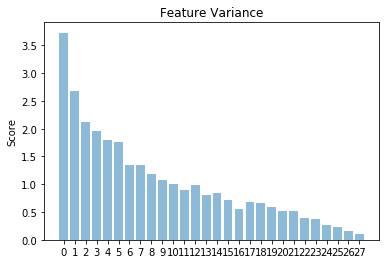

[(0, 'V1'), (1, 'V2'), (2, 'V3'), (3, 'V4'), (4, 'V5'), (5, 'V6'), (6, 'V7'), (7, 'V8'), (8, 'V9'), (9, 'V10'), (10, 'V11'), (11, 'V12'), (12, 'V13'), (13, 'V14'), (14, 'V15'), (15, 'V16'), (16, 'V17'), (17, 'V18'), (18, 'V19'), (19, 'V20'), (20, 'V21'), (21, 'V22'), (22, 'V23'), (23, 'V24'), (24, 'V25'), (25, 'V26'), (26, 'V27'), (27, 'V28')]
	+ Plotting F-score Regression


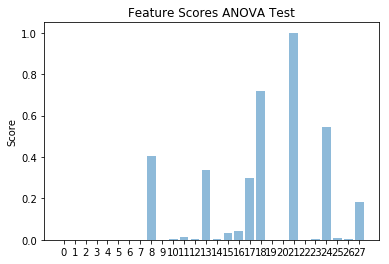

[(0, 'V1'), (1, 'V2'), (2, 'V3'), (3, 'V4'), (4, 'V5'), (5, 'V6'), (6, 'V7'), (7, 'V8'), (8, 'V9'), (9, 'V10'), (10, 'V11'), (11, 'V12'), (12, 'V13'), (13, 'V14'), (14, 'V15'), (15, 'V16'), (16, 'V17'), (17, 'V18'), (18, 'V19'), (19, 'V20'), (20, 'V21'), (21, 'V22'), (22, 'V23'), (23, 'V24'), (24, 'V25'), (25, 'V26'), (26, 'V27'), (27, 'V28')]


In [6]:
# Compute and plot feature score
feature_scores = computeFeatureScores(dataset_X_train, dataset_Y_train, dataset_X_train.columns)

## Initial Model Selection
Look for possible model worth exploring. Run the
following models from list_model with default parameter to see which model is
worth
exploring further.

In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(dataset_X_train, dataset_Y_train, train_size = 0.7, test_size = 0.3, random_state = 0)
def scoreModel(model_name, model, train_X, train_Y, test_X, test_Y):
	time0 = time()
	result = model.fit(train_X, train_Y).score(test_X, test_Y)
	time1 = time()
	return (model_name, result, time1 - time0)
results = Parallel(n_jobs = -1, verbose = 50)(delayed(scoreModel)(model_name, model, train_X, train_Y, test_X, test_Y) for model_name, model in list_model)
results = sorted(results, key = lambda x: x[1], reverse = True)
for model_name, result, run_time in results:
	print("############### Model: {} ######################".format(model_name))
	print("Score: {}\Run Time: {}".format(result, run_time))
	print("-----------------------------------------------")

del train_X, test_X, train_Y, test_Y

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    8.4s remaining:   37.8s
[Parallel(n_jobs=-1)]: Done   3 out of  11 | elapsed:   37.6s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:   49.0s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of  11 | elapsed:  1.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:  2.3min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:  3.9min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:  4.1min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   9 out of  11 | elapsed:  4.1min remaining:   54.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  6.3min finished
############### Model: MLP Regressor ######################
Sc

## Conclusion from Initial Model Selection
Based on the results, the following
models are worth exploring for:
  * MLPRegressor: This model does have high R2
score from initial model selection phase. However, it seems to be overkill.
Nevertheless, it is still worth exploring
  * ExtraTreesRegressor: This model
performed quite well, having second highest R2 score from initial model
selection phase
  * BaggingRegressor: This model performed quite well, having
third highest R2 score from initial model selection phase
  *
RandomForestRegressor: This model performed quite well, having third highest R2
score from initial model selection phase

Furthermore, the features seem to be
the result of dimensionality reduction, which
means that we might not need to do
further featue engineering. Probably, selecting a
subset of features would be
sufficient to produce high quality features for the models.

## ExtraTreesRegressor
### Find Optimal Subset of Features

In [8]:
model_specification = model_specification_default
model_specification["feature_selection"] = {"data" : FeatureSelection.SelectKBest(FeatureSelection.f_regression),
                                            "parameter" : {"k" : list(range(1, 29))}}
model_specification["model"] = {"data" : ExtraTreesRegressor(),
                                "parameter" : {}}
result = runModel(model_specification, dataset_X_train, dataset_Y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 10.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 10.9min finished


/home/chaos/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [9]:
printScore(result.cv_results_)

	============= Train ================


,mean_train_explained_variance,mean_train_neg_mean_absolute_error,mean_train_neg_mean_squared_error,mean_train_neg_median_absolute_error,mean_train_r2
0,0.999378,-3.446487e-01,-3.730714e+01,0.0,0.999378
1,1.000000,-6.297095e-06,-1.577422e-05,0.0,1.000000
2,1.000000,-6.883645e-15,-9.605646e-28,0.0,1.000000
3,1.000000,-6.884831e-15,-9.606662e-28,0.0,1.000000
4,1.000000,-6.886340e-15,-9.609078e-28,0.0,1.000000
5,1.000000,-6.886028e-15,-9.607333e-28,0.0,1.000000
6,1.000000,-6.885789e-15,-9.606789e-28,0.0,1.000000
7,1.000000,-6.886873e-15,-9.607792e-28,0.0,1.000000
8,1.000000,-1.005524e-06,-4.022096e-07,0.0,1.000000
9,1.000000,-6.886949e-15,-9.608323e-28,0.0,1.000000


,std_train_explained_variance,std_train_neg_mean_absolute_error,std_train_neg_mean_squared_error,std_train_neg_median_absolute_error,std_train_r2
0,5.301101e-05,1.683246e-02,4.171027e+00,0.0,5.301101e-05
1,5.427443e-10,1.259419e-05,3.154844e-05,0.0,5.427443e-10
2,0.000000e+00,2.244049e-16,5.978904e-29,0.0,0.000000e+00
3,0.000000e+00,2.247526e-16,5.983047e-29,0.0,0.000000e+00
4,0.000000e+00,2.235217e-16,5.976124e-29,0.0,0.000000e+00
5,0.000000e+00,2.250549e-16,5.980874e-29,0.0,0.000000e+00
6,0.000000e+00,2.247238e-16,5.982224e-29,0.0,0.000000e+00
7,0.000000e+00,2.245794e-16,5.981106e-29,0.0,0.000000e+00
8,1.350089e-11,2.011048e-06,8.044193e-07,0.0,1.350089e-11
9,0.000000e+00,2.239096e-16,5.971594e-29,0.0,0.000000e+00




	============= Test = ===============


,mean_test_explained_variance,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_median_absolute_error,mean_test_r2
0,-0.036076,-89.706279,-61970.390448,-31.847909,-0.036742
1,0.700769,-52.487945,-18359.320246,-23.789591,0.699495
2,0.831435,-37.859624,-9913.686929,-19.095702,0.831109
3,0.924972,-28.520516,-4451.833920,-15.183210,0.924917
4,0.938965,-21.572211,-3665.473413,-10.070820,0.938911
5,0.936799,-20.074981,-3852.922396,-8.778707,0.936768
6,0.946095,-17.237643,-3176.157890,-7.815504,0.946080
7,0.947837,-16.919931,-3099.492095,-7.855705,0.947826
8,0.956755,-16.270140,-2636.639925,-7.758505,0.956745
9,0.957615,-15.915822,-2501.328898,-7.482604,0.957604


,std_test_explained_variance,std_test_neg_mean_absolute_error,std_test_neg_mean_squared_error,std_test_neg_median_absolute_error,std_test_r2
0,0.017160,8.030731,10114.818212,2.524070,0.016946
1,0.051641,7.264979,5879.718023,2.075478,0.051235
2,0.037346,3.531397,2028.685793,1.579883,0.037079
3,0.009297,2.346944,766.813530,1.297030,0.009290
4,0.011786,2.427515,1084.565539,1.979640,0.011792
5,0.014806,1.820320,1421.920771,0.706703,0.014783
6,0.006900,1.612444,398.895662,0.573126,0.006891
7,0.013294,1.517983,928.458122,0.583218,0.013290
8,0.014460,1.639234,1225.237283,0.631487,0.014451
9,0.011426,1.344412,753.879399,0.514785,0.011416


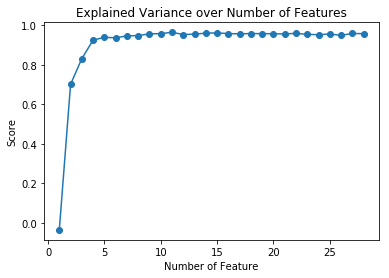

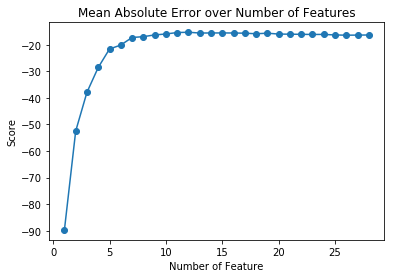

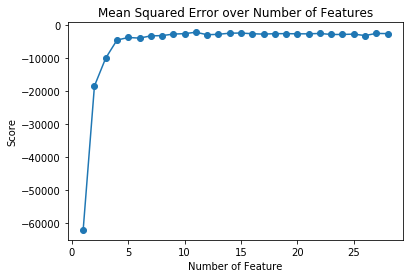

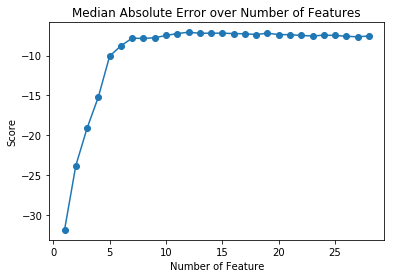

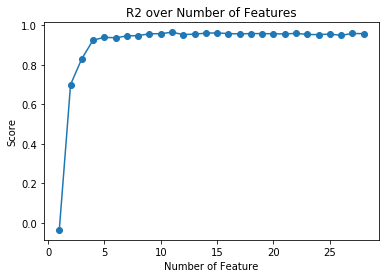

In [10]:
plotScore(list(range(1, 29)), result.cv_results_["mean_test_explained_variance"], "Number of Feature", "Score", "Explained Variance over Number of Features")
plotScore(list(range(1, 29)), result.cv_results_["mean_test_neg_mean_absolute_error"], "Number of Feature", "Score", "Mean Absolute Error over Number of Features")
plotScore(list(range(1, 29)), result.cv_results_["mean_test_neg_mean_squared_error"], "Number of Feature", "Score", "Mean Squared Error over Number of Features")
plotScore(list(range(1, 29)), result.cv_results_["mean_test_neg_median_absolute_error"], "Number of Feature", "Score", "Median Absolute Error over Number of Features")
plotScore(list(range(1, 29)), result.cv_results_["mean_test_r2"], "Number of Feature", "Score", "R2 over Number of Features")

From the number of feature result, it seems like the optimal result is around 14
features.

### See the Effect of Number of Estimators

In [12]:
model_specification = model_specification_default
model_specification["feature_selection"] = {"data" : FeatureSelection.SelectKBest(FeatureSelection.f_regression),
                                            "parameter" : {"k" : [14]}}
model_specification["model"] = {"data" : ExtraTreesRegressor(),
                                "parameter" : {"n_estimators" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                                               "bootstrap" : [True, False]}}
result = runModel(model_specification, dataset_X_train, dataset_Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1

In [13]:
printScore(result.cv_results_)

	============= Train ================


,param_model__bootstrap,param_model__n_estimators,mean_train_explained_variance,mean_train_neg_mean_absolute_error,mean_train_neg_mean_squared_error,mean_train_neg_median_absolute_error,mean_train_r2
0,True,5,0.989871,-7.579283e+00,-6.065740e+02,-2.477200e+00,0.989870
1,True,10,0.991558,-6.668604e+00,-5.028598e+02,-2.620600e+00,0.991558
2,True,15,0.992127,-6.138402e+00,-4.671631e+02,-2.531800e+00,0.992127
3,True,20,0.993652,-5.874738e+00,-3.790986e+02,-2.485100e+00,0.993652
4,True,25,0.993220,-5.707134e+00,-4.037836e+02,-2.439520e+00,0.993220
5,True,30,0.994261,-5.552918e+00,-3.420825e+02,-2.400433e+00,0.994261
6,True,35,0.994472,-5.466793e+00,-3.297831e+02,-2.379543e+00,0.994472
7,True,40,0.994449,-5.371038e+00,-3.315669e+02,-2.361425e+00,0.994449
8,True,45,0.994372,-5.322769e+00,-3.358214e+02,-2.344422e+00,0.994372
9,True,50,0.994994,-5.261652e+00,-2.992150e+02,-2.328300e+00,0.994994


,param_model__bootstrap,param_model__n_estimators,std_train_explained_variance,std_train_neg_mean_absolute_error,std_train_neg_mean_squared_error,std_train_neg_median_absolute_error,std_train_r2
0,True,5,1.627131e-03,1.534671e-01,9.921056e+01,0.084272,1.627086e-03
1,True,10,1.951355e-03,9.773502e-02,1.075500e+02,0.057885,1.951387e-03
2,True,15,3.500692e-03,1.362148e-01,1.971878e+02,0.060905,3.500675e-03
3,True,20,1.456925e-03,1.184867e-01,8.235454e+01,0.050390,1.456989e-03
4,True,25,1.619049e-03,1.086633e-01,8.897175e+01,0.054823,1.619065e-03
5,True,30,1.122837e-03,1.167485e-01,5.994767e+01,0.057968,1.122876e-03
6,True,35,6.668122e-04,1.157605e-01,3.171254e+01,0.055806,6.668473e-04
7,True,40,5.654908e-04,1.222647e-01,2.969753e+01,0.058282,5.655423e-04
8,True,45,1.080552e-03,1.186216e-01,5.931207e+01,0.056695,1.080565e-03
9,True,50,3.682266e-04,1.119820e-01,1.948207e+01,0.043359,3.682244e-04




	============= Test = ===============


,param_model__bootstrap,param_model__n_estimators,mean_test_explained_variance,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error,mean_test_neg_median_absolute_error,mean_test_r2
0,True,5,0.952007,-18.436187,-2897.315265,-8.483006,0.951999
1,True,10,0.958473,-16.588022,-2446.930216,-7.957305,0.958464
2,True,15,0.951254,-15.857066,-2798.175667,-7.553737,0.951244
3,True,20,0.959106,-15.400458,-2428.393933,-7.384653,0.959098
4,True,25,0.956292,-15.173189,-2536.159637,-7.350764,0.956282
5,True,30,0.959008,-15.095835,-2450.347482,-7.232570,0.959001
6,True,35,0.958331,-14.999337,-2441.081153,-7.164461,0.958323
7,True,40,0.961064,-14.768647,-2245.580330,-7.133328,0.961054
8,True,45,0.957945,-14.787984,-2456.638816,-7.105826,0.957935
9,True,50,0.961588,-14.632982,-2233.782013,-7.087484,0.961579


,param_model__bootstrap,param_model__n_estimators,std_test_explained_variance,std_test_neg_mean_absolute_error,std_test_neg_mean_squared_error,std_test_neg_median_absolute_error,std_test_r2
0,True,5,0.010594,1.763884,954.937460,0.724314,0.010587
1,True,10,0.010974,1.601764,668.761841,0.628977,0.010969
2,True,15,0.020224,1.394507,820.675417,0.505306,0.020218
3,True,20,0.010410,1.391539,740.625937,0.479697,0.010403
4,True,25,0.012271,1.275367,447.874986,0.495232,0.012266
5,True,30,0.007033,1.468551,609.818266,0.500718,0.007028
6,True,35,0.010925,1.326738,585.111319,0.449809,0.010921
7,True,40,0.011515,1.206022,390.108787,0.433925,0.011511
8,True,45,0.009858,1.303514,416.851477,0.474534,0.009852
9,True,50,0.010929,1.310054,456.999352,0.480725,0.010925


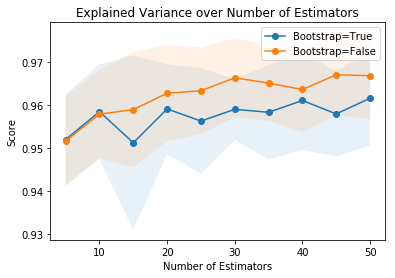

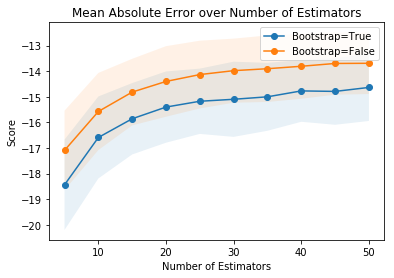

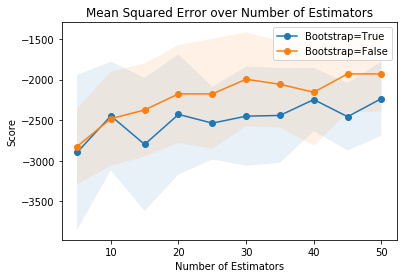

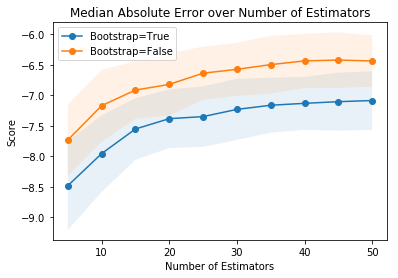

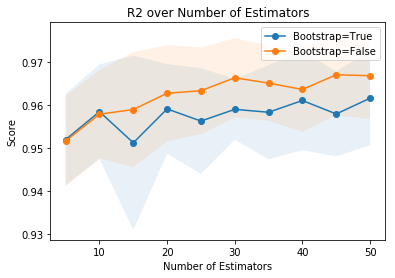

In [14]:
mask = result.cv_results_["param_model__bootstrap"] == True
plot_x = [[int(x) for x in result.cv_results_["param_model__n_estimators"][mask]], [int(x) for x in result.cv_results_["param_model__n_estimators"][mask == False]]]
plot_line_label = ["Bootstrap=True", "Bootstrap=False"]
for score_name, score in list_score:
	plot_y = [result.cv_results_["mean_test_{}".format(score)][mask], result.cv_results_["mean_test_{}".format(score)][mask == False]]
	plot_y_std = [result.cv_results_["std_test_{}".format(score)][mask], result.cv_results_["std_test_{}".format(score)][mask == False]]
	plotMultiLineScore(plot_x, plot_y, plot_y_std, plot_line_label, "Number of Estimators", "Score", "{} over Number of Estimators".format(score_name))

Based on the analysis of number of estimators and whether to use bootstrap or
not, it seems that the optimum number of estimators is 45 with no bootstrap.
### Check the Learning Curve to See If the Model Overfits

[learning_curve] Training set sizes: [ 15912  51714  87516 123318 159121]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  25 | elapsed:    9.1s remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   2 out of  25 | elapsed:   10.6s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   3 out of  25 | elapsed:   32.6s remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   4 out of  25 | elapsed:   37.5s remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:   40.6s remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed:   58.4s remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   7 out of  25 | elapsed:  1.0min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:  1.2min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   9 out of  25 | elapsed:  1.3min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  11 out of  

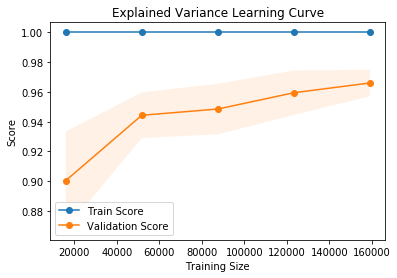

[learning_curve] Training set sizes: [ 15912  51714  87516 123318 159121]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  25 | elapsed:    8.3s remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   2 out of  25 | elapsed:    9.1s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   3 out of  25 | elapsed:   30.5s remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   4 out of  25 | elapsed:   30.5s remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:   38.7s remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed:   56.1s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   7 out of  25 | elapsed:   59.8s remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:  1.0min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   9 out of  25 | elapsed:  1.2min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  11 out of  

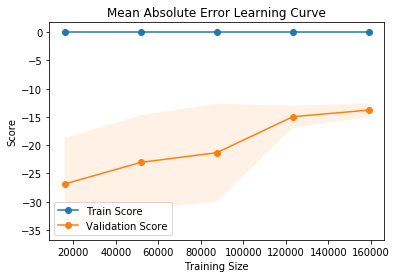

[learning_curve] Training set sizes: [ 15912  51714  87516 123318 159121]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  25 | elapsed:    8.9s remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   2 out of  25 | elapsed:    9.0s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   3 out of  25 | elapsed:   33.0s remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   4 out of  25 | elapsed:   33.5s remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:   42.7s remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed:   56.5s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   7 out of  25 | elapsed:   58.5s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:  1.1min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   9 out of  25 | elapsed:  1.3min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  11 out of  

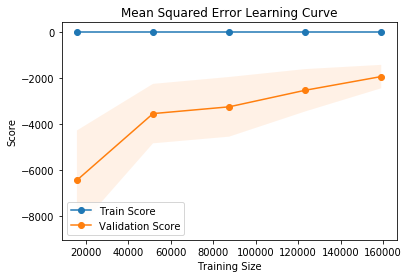

[learning_curve] Training set sizes: [ 15912  51714  87516 123318 159121]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  25 | elapsed:    8.8s remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   2 out of  25 | elapsed:    8.9s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   3 out of  25 | elapsed:   31.1s remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   4 out of  25 | elapsed:   32.4s remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:   40.7s remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed:   57.1s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   7 out of  25 | elapsed:   59.3s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:  1.1min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  25 | elapsed:  1.2min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  11 out of  

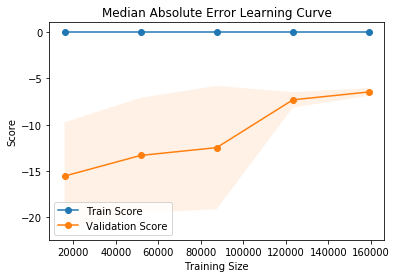

[learning_curve] Training set sizes: [ 15912  51714  87516 123318 159121]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  25 | elapsed:    8.6s remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   2 out of  25 | elapsed:    8.9s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   3 out of  25 | elapsed:   31.4s remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   4 out of  25 | elapsed:   33.0s remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:   40.0s remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed:   54.1s remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   7 out of  25 | elapsed:   56.4s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:  1.1min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  25 | elapsed:  1.2min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  11 out of  

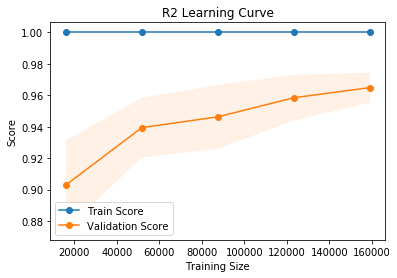

In [15]:
for score_name, score in list_score:
	train_sizes, train_scores, valid_scores = learning_curve(Pipeline(steps = [("feature_selection", FeatureSelection.SelectKBest(FeatureSelection.f_regression, k = 14)),
	                                                                           ("model", ExtraTreesRegressor(n_estimators = 45, bootstrap = False))]),
	                                                         dataset_X_train, dataset_Y_train, scoring = score,
	                                                         train_sizes = np.linspace(0.1, 1.0, 5), cv = 5, n_jobs = -1, verbose = 50)
	train_scores_mean = np.mean(train_scores, axis = 1)
	train_scores_std = np.std(train_scores, axis = 1)
	valid_scores_mean = np.mean(valid_scores, axis = 1)
	valid_scores_std = np.std(valid_scores, axis = 1)
	plotMultiLineScore([train_sizes, train_sizes], [train_scores_mean, valid_scores_mean], [train_scores_std, valid_scores_std], ["Train Score", "Validation Score"],
	                   "Training Size", "Score", "{} Learning Curve".format(score_name))

Based on the Learning Curve analysis, it seems that the model does not overfit
since the validation curve still increases with the increase of train size.

### Final Model

In [11]:
model_ExtraTreesRegressor = Pipeline(steps = [("feature_selection", FeatureSelection.SelectKBest(FeatureSelection.f_regression, k = 14)),
                                              ("model", ExtraTreesRegressor(n_estimators = 45, bootstrap = False, n_jobs = -1))])
model_ExtraTreesRegressor = model_ExtraTreesRegressor.fit(dataset_X_train, dataset_Y_train)

# Save model
pickle.dump(model_ExtraTreesRegressor, open("../Model/ExtraTreesRegressor_final.pkl", "wb"))

# Predict and record score
Y_prediction_ExtraTreesRegressor = model_ExtraTreesRegressor.predict(dataset_X_test)

# Print out Scores
printModelScore(dataset_Y_test, Y_prediction_ExtraTreesRegressor)

	+ Explained Variance: 0.9334235272196703
	+ Mean Absolute Error: 12.34057950325022
	+ Mean Squared Error: 4581.311761707121
	+ Median Absolute Error: 5.205555555555557
	+ R2 Score: 0.9334214546995104


### Conclusion from Final Model
The final model has R2 score of 0.933 while only using 14 features out of 28. 

## BaggingRegressor
### Find Optimal Subset of Features

## RandomForestRegressor
### Find Optimal Subset of Features

## MLPRegressor
### Find Optimal Subset of Features


# Save Jupyter Session

In [17]:
dill.dump_session(path_session)